In [44]:
# Initial Imports
import pandas as pd
import numpy as np
from pathlib import Path
from dotenv import load_dotenv
import time
from joblib import dump,load # Save Models
from numpy import random
import os
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt

## Pre-Process Data

In [45]:
# Read CSV into dataframes
btcusd_6h_historical_csv = Path('df_candles_kraken_btcusd_6h_append_9102.csv')
btcusd_6h_historical = pd.read_csv(btcusd_6h_historical_csv,index_col="time")
# make sure rows are every 6hrs, if there is no row-then make one and forward fill data (shrimpy doesn't print candle if there is no tick)

ethbtc_6h_historical_csv = Path('df_prices_kraken_ethbtc_6h_historical_20181003_20200925.csv')
ethbtc_6h_historical = pd.read_csv(ethbtc_6h_historical_csv, index_col="time")

In [46]:
btcusd_6h_historical.reset_index(inplace=True)

In [47]:
btcusd_6h_historical.head()

,time,close
0,2013-10-06 18:00:00+00:00,122.00
1,2013-10-07 18:00:00+00:00,123.61
2,2013-10-08 00:00:00+00:00,124.18
3,2013-10-09 06:00:00+00:00,123.84
4,2013-10-10 18:00:00+00:00,125.86


In [48]:
date_list = pd.date_range(start='10/06/2013', end='09/29/2020',freq='6H')
date_list

DatetimeIndex(['2013-10-06 00:00:00', '2013-10-06 06:00:00',
               '2013-10-06 12:00:00', '2013-10-06 18:00:00',
               '2013-10-07 00:00:00', '2013-10-07 06:00:00',
               '2013-10-07 12:00:00', '2013-10-07 18:00:00',
               '2013-10-08 00:00:00', '2013-10-08 06:00:00',
               ...
               '2020-09-26 18:00:00', '2020-09-27 00:00:00',
               '2020-09-27 06:00:00', '2020-09-27 12:00:00',
               '2020-09-27 18:00:00', '2020-09-28 00:00:00',
               '2020-09-28 06:00:00', '2020-09-28 12:00:00',
               '2020-09-28 18:00:00', '2020-09-29 00:00:00'],
              dtype='datetime64[ns]', length=10201, freq='6H')

In [49]:
date_strings = [str(x) for x in date_list][3:]

In [50]:
date_strings_df = pd.DataFrame(date_strings, columns = ['time'])

In [51]:
type(date_strings_df['time'][0])

str

In [52]:
print(date_strings_df['time'][0])

2013-10-06 18:00:00


In [53]:
print(btcusd_6h_historical['time'][0])

2013-10-06 18:00:00+00:00


In [54]:
date_strings_df['time'] = [(x+"+00:00") for x in date_strings_df['time']]
date_strings_df['time'].head()

0    2013-10-06 18:00:00+00:00
1    2013-10-07 00:00:00+00:00
2    2013-10-07 06:00:00+00:00
3    2013-10-07 12:00:00+00:00
4    2013-10-07 18:00:00+00:00
Name: time, dtype: object

In [55]:
date_strings_df['time'][0] == btcusd_6h_historical['time'][0]

True

In [56]:
btcusd_6h_historical_full = pd.merge(date_strings_df, btcusd_6h_historical, on='time', how='left')

In [57]:
btcusd_6h_historical_ffill = btcusd_6h_historical_full.fillna(method="ffill")

In [58]:
btcusd_6h_historical_ffill = btcusd_6h_historical_ffill[0:-16]

In [59]:
btcusd_6h_historical_ffill.head()

,time,close
0,2013-10-06 18:00:00+00:00,122.00
1,2013-10-07 00:00:00+00:00,122.00
2,2013-10-07 06:00:00+00:00,122.00
3,2013-10-07 12:00:00+00:00,122.00
4,2013-10-07 18:00:00+00:00,123.61


## Generate Features

In [60]:
# make sure rows are every 6hrs, if there is no row-then make one and forward fill data (shrimpy doesn't print candle if there is no tick)
def calc_feature_dataframe(prices_df):
    ## cumulative returns as velocity
    ## Log returns as velocity
    ## partials?
    ## Lags?
    ## stock to flow
    ## Technical Indicators
    ## Social Indicators

    df_features = prices_df
    # Construct dependent variable
    df_features['returns'] = df_features['close'].pct_change()
    # Calculate cumulative returns
    df_features['cum_returns'] = (df_features['returns']+1).cumprod()
    # ----------------------- Price Dynamics --------------------------------
    # price dynamics as a one Dimensional particle problem in physics
    df_features['price_velocity_2'] = df_features['close'].pct_change(2)
    df_features['price_velocity_3'] = df_features['close'].pct_change(3)
    df_features['price_velocity_4'] = df_features['close'].pct_change(4)
    df_features['price_velocity_7'] = df_features['close'].pct_change(7)
    df_features['price_velocity_30'] = df_features['close'].pct_change(30)
    
    df_features['price_acceleration_1'] = df_features['returns'].pct_change(1)
    df_features['price_acceleration_2'] = df_features['price_velocity_2'].pct_change(2)
    df_features['price_acceleration_3'] = df_features['price_velocity_3'].pct_change(3)
    df_features['price_acceleration_4'] = df_features['price_velocity_4'].pct_change(4)
    df_features['price_acceleration_7'] = df_features['price_velocity_7'].pct_change(7)
    df_features['price_acceleration_30'] = df_features['price_velocity_30'].pct_change(30)

    df_features['rolling_mean_velocity_2'] = df_features['returns'].rolling(window=2).mean()
    df_features['rolling_mean_velocity_3'] = df_features['returns'].rolling(window=3).mean()
    df_features['rolling_mean_velocity_4'] = df_features['returns'].rolling(window=4).mean()
    df_features['rolling_mean_velocity_7'] = df_features['returns'].rolling(window=7).mean()
    df_features['rolling_mean_velocity_30'] = df_features['returns'].rolling(window=30).mean()
    
    df_features['rolling_mean_acceleration_2'] = df_features['price_acceleration_1'].rolling(window=2).mean()
    df_features['rolling_mean_acceleration_3'] = df_features['price_acceleration_1'].rolling(window=3).mean()
    #df_features['rolling_mean_acceleration_4'] = df_features['price_acceleration_1'].rolling(window=4).mean()
    #df_features['rolling_mean_acceleration_7'] = df_features['price_acceleration_1'].rolling(window=7).mean()
    #df_features['rolling_mean_acceleration_30'] = df_features['price_acceleration_1'].rolling(window=30).mean()
    # To extend space to entire line the log price is mapped to position x(t) in the space by
    # x(t) = log(S(t))   where S(t) is the price of the instrument
    #df_features['log_price'] = np.log(df_features['close'])
    #df_features['log_returns'] = df_features['log_price'].diff() # Diff or percent change
    #df_features['log_return_pct']  = df_features['log_price'].pct_change()
    #df_features['cum_log_returns'] =(df_features['log_returns_pct'] + 1).cumprod()
    # Assumption: Returns of financial instruments are lognormally distributed
    # v(t) = R(t) = dx(t)/dt where v(t) is the velocity of the instrument in the log price space, x(t)
    
    # ------------------------------ partial price dynamics ---------------------
    # -------------------------------Technical Indicators ------------------------
    df_features.dropna(inplace=True)
    return df_features

In [61]:
df_features = calc_feature_dataframe(btcusd_6h_historical_ffill)
df_features.head()

,time,close,returns,cum_returns,price_velocity_2,price_velocity_3,price_velocity_4,price_velocity_7,price_velocity_30,price_acceleration_1,...,price_acceleration_4,price_acceleration_7,price_acceleration_30,rolling_mean_velocity_2,rolling_mean_velocity_3,rolling_mean_velocity_4,rolling_mean_velocity_7,rolling_mean_velocity_30,rolling_mean_acceleration_2,rolling_mean_acceleration_3
60,2013-10-21 18:00:00+00:00,176.32429,0.000000,1.445281,-0.001859,0.068632,0.081870,0.058838,0.322096,-1.000000,...,-6.255693,-0.563894,2.456918,-0.000930,0.022921,0.020288,0.008552,0.009660,-1.013165,0.891534
65,2013-10-23 00:00:00+00:00,192.28087,0.281872,1.576073,-0.008861,0.056662,0.090496,0.088468,0.436221,-2.242801,...,0.318562,-0.132198,4.584668,0.027534,0.040393,0.038299,0.021620,0.014632,-3.336760,-1.869603
66,2013-10-23 06:00:00+00:00,192.31047,0.000154,1.576315,0.282070,-0.008709,0.056825,0.090664,0.436442,-0.999454,...,0.887885,0.394449,4.587499,0.141013,0.018407,0.030333,0.021907,0.014637,-1.621128,-2.557658
67,2013-10-23 12:00:00+00:00,192.99459,0.003557,1.581923,0.003712,0.286631,-0.005183,0.094543,0.353673,22.108605,...,-1.051698,0.606850,1.388078,0.001856,0.095195,0.014695,0.022415,0.012592,10.554575,6.288783
68,2013-10-23 18:00:00+00:00,203.45000,0.054175,1.667623,0.057925,0.058088,0.356333,0.153840,0.399436,14.228831,...,-3.386777,0.879086,1.339715,0.028866,0.019295,0.084940,0.030155,0.013741,18.168718,11.779327


In [62]:
df_features.isna().sum()

time                           0
close                          0
returns                        0
cum_returns                    0
price_velocity_2               0
price_velocity_3               0
price_velocity_4               0
price_velocity_7               0
price_velocity_30              0
price_acceleration_1           0
price_acceleration_2           0
price_acceleration_3           0
price_acceleration_4           0
price_acceleration_7           0
price_acceleration_30          0
rolling_mean_velocity_2        0
rolling_mean_velocity_3        0
rolling_mean_velocity_4        0
rolling_mean_velocity_7        0
rolling_mean_velocity_30       0
rolling_mean_acceleration_2    0
rolling_mean_acceleration_3    0
dtype: int64

In [63]:
df_features.isna().sum()

time                           0
close                          0
returns                        0
cum_returns                    0
price_velocity_2               0
price_velocity_3               0
price_velocity_4               0
price_velocity_7               0
price_velocity_30              0
price_acceleration_1           0
price_acceleration_2           0
price_acceleration_3           0
price_acceleration_4           0
price_acceleration_7           0
price_acceleration_30          0
rolling_mean_velocity_2        0
rolling_mean_velocity_3        0
rolling_mean_velocity_4        0
rolling_mean_velocity_7        0
rolling_mean_velocity_30       0
rolling_mean_acceleration_2    0
rolling_mean_acceleration_3    0
dtype: int64

In [64]:
df_features.set_index("time", drop=True, inplace=True)

## XG Boost Classifier

In [65]:
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn import svm
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [66]:
df_features.head()

,close,returns,cum_returns,price_velocity_2,price_velocity_3,price_velocity_4,price_velocity_7,price_velocity_30,price_acceleration_1,price_acceleration_2,...,price_acceleration_4,price_acceleration_7,price_acceleration_30,rolling_mean_velocity_2,rolling_mean_velocity_3,rolling_mean_velocity_4,rolling_mean_velocity_7,rolling_mean_velocity_30,rolling_mean_acceleration_2,rolling_mean_acceleration_3
time,,,,,,,,,,,,,,,,,,,,,
2013-10-21 18:00:00+00:00,176.32429,0.000000,1.445281,-0.001859,0.068632,0.081870,0.058838,0.322096,-1.000000,-1.022167,...,-6.255693,-0.563894,2.456918,-0.000930,0.022921,0.020288,0.008552,0.009660,-1.013165,0.891534
2013-10-23 00:00:00+00:00,192.28087,0.281872,1.576073,-0.008861,0.056662,0.090496,0.088468,0.436221,-2.242801,-1.088398,...,0.318562,-0.132198,4.584668,0.027534,0.040393,0.038299,0.021620,0.014632,-3.336760,-1.869603
2013-10-23 06:00:00+00:00,192.31047,0.000154,1.576315,0.282070,-0.008709,0.056825,0.090664,0.436442,-0.999454,-2.605513,...,0.887885,0.394449,4.587499,0.141013,0.018407,0.030333,0.021907,0.014637,-1.621128,-2.557658
2013-10-23 12:00:00+00:00,192.99459,0.003557,1.581923,0.003712,0.286631,-0.005183,0.094543,0.353673,22.108605,-1.418875,...,-1.051698,0.606850,1.388078,0.001856,0.095195,0.014695,0.022415,0.012592,10.554575,6.288783
2013-10-23 18:00:00+00:00,203.45000,0.054175,1.667623,0.057925,0.058088,0.356333,0.153840,0.399436,14.228831,-0.794644,...,-3.386777,0.879086,1.339715,0.028866,0.019295,0.084940,0.030155,0.013741,18.168718,11.779327


In [67]:
# Create Class Column with bin logic
bin_labels_5 = ['1', '2', '3', '4', '5']
class_df = df_features.copy()
class_df['return_class'] = pd.cut(df_features.returns,
                              bins=[-np.inf, -.003,-.00125, .00125, .003, np.inf], labels=bin_labels_5)

cleanup_nums = {"return_class": {"1": round(1), "2": round(2), "3": round(3), "4": round(4), "5": round(5)}}
class_df.replace(cleanup_nums, inplace=True)

In [68]:
class_df.head()

,close,returns,cum_returns,price_velocity_2,price_velocity_3,price_velocity_4,price_velocity_7,price_velocity_30,price_acceleration_1,price_acceleration_2,...,price_acceleration_7,price_acceleration_30,rolling_mean_velocity_2,rolling_mean_velocity_3,rolling_mean_velocity_4,rolling_mean_velocity_7,rolling_mean_velocity_30,rolling_mean_acceleration_2,rolling_mean_acceleration_3,return_class
time,,,,,,,,,,,,,,,,,,,,,
2013-10-21 18:00:00+00:00,176.32429,0.000000,1.445281,-0.001859,0.068632,0.081870,0.058838,0.322096,-1.000000,-1.022167,...,-0.563894,2.456918,-0.000930,0.022921,0.020288,0.008552,0.009660,-1.013165,0.891534,3
2013-10-23 00:00:00+00:00,192.28087,0.281872,1.576073,-0.008861,0.056662,0.090496,0.088468,0.436221,-2.242801,-1.088398,...,-0.132198,4.584668,0.027534,0.040393,0.038299,0.021620,0.014632,-3.336760,-1.869603,5
2013-10-23 06:00:00+00:00,192.31047,0.000154,1.576315,0.282070,-0.008709,0.056825,0.090664,0.436442,-0.999454,-2.605513,...,0.394449,4.587499,0.141013,0.018407,0.030333,0.021907,0.014637,-1.621128,-2.557658,3
2013-10-23 12:00:00+00:00,192.99459,0.003557,1.581923,0.003712,0.286631,-0.005183,0.094543,0.353673,22.108605,-1.418875,...,0.606850,1.388078,0.001856,0.095195,0.014695,0.022415,0.012592,10.554575,6.288783,5
2013-10-23 18:00:00+00:00,203.45000,0.054175,1.667623,0.057925,0.058088,0.356333,0.153840,0.399436,14.228831,-0.794644,...,0.879086,1.339715,0.028866,0.019295,0.084940,0.030155,0.013741,18.168718,11.779327,5


In [69]:
l2 = list(class_df['return_class'][1:])
#l2.append(np.nan)
l2[0:5]

[5, 3, 5, 5, 1]

In [70]:
l3 = [round(int(x),0) for x in l2]

In [71]:
l3.append(np.nan)

In [72]:
class_df['return_class_shifted'] = l3
class_df.head()

,close,returns,cum_returns,price_velocity_2,price_velocity_3,price_velocity_4,price_velocity_7,price_velocity_30,price_acceleration_1,price_acceleration_2,...,price_acceleration_30,rolling_mean_velocity_2,rolling_mean_velocity_3,rolling_mean_velocity_4,rolling_mean_velocity_7,rolling_mean_velocity_30,rolling_mean_acceleration_2,rolling_mean_acceleration_3,return_class,return_class_shifted
time,,,,,,,,,,,,,,,,,,,,,
2013-10-21 18:00:00+00:00,176.32429,0.000000,1.445281,-0.001859,0.068632,0.081870,0.058838,0.322096,-1.000000,-1.022167,...,2.456918,-0.000930,0.022921,0.020288,0.008552,0.009660,-1.013165,0.891534,3,5.0
2013-10-23 00:00:00+00:00,192.28087,0.281872,1.576073,-0.008861,0.056662,0.090496,0.088468,0.436221,-2.242801,-1.088398,...,4.584668,0.027534,0.040393,0.038299,0.021620,0.014632,-3.336760,-1.869603,5,3.0
2013-10-23 06:00:00+00:00,192.31047,0.000154,1.576315,0.282070,-0.008709,0.056825,0.090664,0.436442,-0.999454,-2.605513,...,4.587499,0.141013,0.018407,0.030333,0.021907,0.014637,-1.621128,-2.557658,3,5.0
2013-10-23 12:00:00+00:00,192.99459,0.003557,1.581923,0.003712,0.286631,-0.005183,0.094543,0.353673,22.108605,-1.418875,...,1.388078,0.001856,0.095195,0.014695,0.022415,0.012592,10.554575,6.288783,5,5.0
2013-10-23 18:00:00+00:00,203.45000,0.054175,1.667623,0.057925,0.058088,0.356333,0.153840,0.399436,14.228831,-0.794644,...,1.339715,0.028866,0.019295,0.084940,0.030155,0.013741,18.168718,11.779327,5,1.0


In [73]:
class_df.return_class.value_counts()

5    2943
1    2537
3    1322
2     469
4     467
Name: return_class, dtype: int64

In [74]:
class_df.columns

Index(['close', 'returns', 'cum_returns', 'price_velocity_2',
       'price_velocity_3', 'price_velocity_4', 'price_velocity_7',
       'price_velocity_30', 'price_acceleration_1', 'price_acceleration_2',
       'price_acceleration_3', 'price_acceleration_4', 'price_acceleration_7',
       'price_acceleration_30', 'rolling_mean_velocity_2',
       'rolling_mean_velocity_3', 'rolling_mean_velocity_4',
       'rolling_mean_velocity_7', 'rolling_mean_velocity_30',
       'rolling_mean_acceleration_2', 'rolling_mean_acceleration_3',
       'return_class', 'return_class_shifted'],
      dtype='object')

In [75]:
class_df.isna().sum()

close                          0
returns                        0
cum_returns                    0
price_velocity_2               0
price_velocity_3               0
price_velocity_4               0
price_velocity_7               0
price_velocity_30              0
price_acceleration_1           0
price_acceleration_2           0
price_acceleration_3           0
price_acceleration_4           0
price_acceleration_7           0
price_acceleration_30          0
rolling_mean_velocity_2        0
rolling_mean_velocity_3        0
rolling_mean_velocity_4        0
rolling_mean_velocity_7        0
rolling_mean_velocity_30       0
rolling_mean_acceleration_2    0
rolling_mean_acceleration_3    0
return_class                   0
return_class_shifted           1
dtype: int64

In [76]:
class_df.return_class = class_df.return_class.astype('int64')

In [77]:
class_df.dropna(inplace=True)

In [78]:
# Create independent variable dataframe
X = class_df.copy()
X.drop(["close", "returns", "return_class", "cum_returns", "return_class_shifted"], axis=1, inplace=True)
# Create dependent variable dataframe
#y = class_df["return_class"].values.reshape(-1, 1)
y = class_df["return_class_shifted"]

In [79]:
# WORK ITEM 2!!
# Split into Training and testing data (CHANGE THIS to sequential split (70/30))
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78, train_size=.7)


### Untuned Base Model

In [80]:
# Train Model on training dataset
base_model = xgb.XGBClassifier(objective='multi:softmax',num_class=5).fit(X_train,y_train)

In [81]:
# Test model on out of sample testing dataset
predictions = base_model.predict(X_test)
predicted_returns = predictions.reshape(-1,1)
real_returns = y_test.values.reshape(-1, 1)

# Create Prediction Dataframe
prediction_xgb = pd.DataFrame({
    "Real": real_returns.ravel(),
    "y_test": y_test.ravel(),
    "Predicted": predicted_returns.ravel()
}, index=X_test.index)


In [82]:
# Create accuracy test column to identify errors in prediction
prediction_xgb['Accuracy_Test'] = np.where(prediction_xgb['Real'] == prediction_xgb['Predicted'], True, False)

In [83]:
prediction_xgb.head()

,Real,y_test,Predicted,Accuracy_Test
time,,,,
2017-09-03 12:00:00+00:00,5.0,5.0,5.0,True
2018-06-10 06:00:00+00:00,1.0,1.0,1.0,True
2016-11-28 00:00:00+00:00,2.0,2.0,3.0,False
2019-06-30 12:00:00+00:00,1.0,1.0,5.0,False
2016-01-26 12:00:00+00:00,2.0,2.0,5.0,False


In [84]:
# Print Value Counts of True and false predictions
print(prediction_xgb['Accuracy_Test'].value_counts())

False    1509
True      813
Name: Accuracy_Test, dtype: int64


In [85]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### Tuning

In [86]:
from sklearn.model_selection import GridSearchCV

In [87]:
xgb_gridsearch=XGBClassifier(objective='multi:softmax', num_class=5)
search_grid={'n_estimators':[500],'learning_rate':[.001,.1],'max_depth':[1,4],'subsample':[.5,.75],'random_state':[1]}
search=GridSearchCV(estimator=xgb_gridsearch,param_grid=search_grid,scoring='accuracy',n_jobs=-1)

In [ ]:
search.fit(X_train,y_train)
search.best_params_

In [ ]:
model = xgb.XGBClassifier(objective='multi:softmax',num_class=5,n_estimators=500, max_delta_step = .3, scale_pos_weight=5,learning_rate=.3,max_depth=5,subsample=1,random_state=1, eval_metric='merror', cv=2, gamma=.1 ).fit(X_train,y_train)

In [ ]:
# Test model on out of sample testing dataset
predictions = model.predict(X_test)
predicted_returns = predictions.reshape(-1,1)
real_returns = y_test.values.reshape(-1, 1)

# Create Prediction Dataframe
prediction_xgb = pd.DataFrame({
    "Real": real_returns.ravel(),
    "y_test": y_test.ravel(),
    "Predicted": predicted_returns.ravel()
}, index=X_test.index)

In [ ]:
prediction_xgb['Accuracy_Test'] = np.where(prediction_xgb['Real'] == prediction_xgb['Predicted'], True, False)

In [ ]:
prediction_xgb.head()

In [ ]:
prediction_xgb['Accuracy_Test'].value_counts()

## Return Analysis

In [62]:
test_df = pd.merge(prediction_xgb, X_test, on='time', how='left')
test_df.head()

,Real,y_test,Predicted,Accuracy_Test,price_velocity_2,price_velocity_3,price_velocity_4,price_velocity_7,price_velocity_30,price_acceleration_1,...,rolling_mean_velocity_2,rolling_mean_velocity_3,rolling_mean_velocity_4,rolling_mean_velocity_7,rolling_mean_velocity_30,rolling_mean_acceleration_2,rolling_mean_acceleration_3,rolling_mean_acceleration_4,rolling_mean_acceleration_7,rolling_mean_acceleration_30
time,,,,,,,,,,,,,,,,,,,,,
2018-10-03 18:00:00+00:00,3,3,3,True,0.001953,0.004913,-0.005554,-0.017465,0.004491,-1.240345,...,0.000977,0.001636,-0.001377,-0.002502,0.000187,-0.684617,-0.884279,-3.828709,-3.348702,0.405056
2018-10-04 00:00:00+00:00,5,5,5,True,0.012384,0.014989,0.017987,0.001177,0.016786,-22.038011,...,0.006196,0.004988,0.004480,0.000193,0.000595,-11.639178,-7.802415,-6.172712,-5.467872,-0.299610
2018-10-04 06:00:00+00:00,2,2,2,True,0.010489,0.009864,0.012463,0.005774,0.000505,-1.191328,...,0.005261,0.003301,0.003119,0.000844,0.000054,-11.614669,-8.156561,-6.149643,-5.667269,-0.907570
2018-10-04 12:00:00+00:00,5,5,5,True,0.000657,0.013676,0.013049,0.008046,0.015310,-2.266958,...,0.000332,0.004558,0.003264,0.001167,0.000542,-1.729143,-8.498765,-6.684160,-5.830162,-0.921974
2018-10-04 18:00:00+00:00,3,3,3,True,0.002404,-0.000092,0.012918,0.017894,0.012746,-1.237116,...,0.001203,-0.000028,0.003232,0.002548,0.000457,-1.752037,-1.565134,-6.683353,-4.198036,-0.924700


In [68]:
test_df = pd.merge(test_df, btcusd_6h_historical, on='time', how='left')
test_df.head()

,Real,y_test,Predicted,Accuracy_Test,price_velocity_2,price_velocity_3,price_velocity_4,price_velocity_7,price_velocity_30,price_acceleration_1,...,rolling_mean_velocity_3,rolling_mean_velocity_4,rolling_mean_velocity_7,rolling_mean_velocity_30,rolling_mean_acceleration_2,rolling_mean_acceleration_3,rolling_mean_acceleration_4,rolling_mean_acceleration_7,rolling_mean_acceleration_30,close
time,,,,,,,,,,,,,,,,,,,,,
2018-10-03 18:00:00+00:00,3,3,3,True,0.001953,0.004913,-0.005554,-0.017465,0.004491,-1.240345,...,0.001636,-0.001377,-0.002502,0.000187,-0.684617,-0.884279,-3.828709,-3.348702,0.405056,6463.9
2018-10-04 00:00:00+00:00,5,5,5,True,0.012384,0.014989,0.017987,0.001177,0.016786,-22.038011,...,0.004988,0.004480,0.000193,0.000595,-11.639178,-7.802415,-6.172712,-5.467872,-0.299610,6548.0
2018-10-04 06:00:00+00:00,2,2,2,True,0.010489,0.009864,0.012463,0.005774,0.000505,-1.191328,...,0.003301,0.003119,0.000844,0.000054,-11.614669,-8.156561,-6.149643,-5.667269,-0.907570,6531.7
2018-10-04 12:00:00+00:00,5,5,5,True,0.000657,0.013676,0.013049,0.008046,0.015310,-2.266958,...,0.004558,0.003264,0.001167,0.000542,-1.729143,-8.498765,-6.684160,-5.830162,-0.921974,6552.3
2018-10-04 18:00:00+00:00,3,3,3,True,0.002404,-0.000092,0.012918,0.017894,0.012746,-1.237116,...,-0.000028,0.003232,0.002548,0.000457,-1.752037,-1.565134,-6.683353,-4.198036,-0.924700,6547.4


In [71]:
test_df = pd.merge(test_df, ethbtc_6h_historical, on='time', how='left')
test_df

,Real,y_test,Predicted,Accuracy_Test,price_velocity_2,price_velocity_3,price_velocity_4,price_velocity_7,price_velocity_30,price_acceleration_1,...,rolling_mean_velocity_4,rolling_mean_velocity_7,rolling_mean_velocity_30,rolling_mean_acceleration_2,rolling_mean_acceleration_3,rolling_mean_acceleration_4,rolling_mean_acceleration_7,rolling_mean_acceleration_30,close_x,close_y
time,,,,,,,,,,,,,,,,,,,,,
2018-10-03 18:00:00+00:00,3,3,3,True,0.001953,0.004913,-0.005554,-0.017465,0.004491,-1.240345,...,-0.001377,-0.002502,0.000187,-0.684617,-0.884279,-3.828709,-3.348702,0.405056,6463.9,0.03391
2018-10-04 00:00:00+00:00,5,5,5,True,0.012384,0.014989,0.017987,0.001177,0.016786,-22.038011,...,0.004480,0.000193,0.000595,-11.639178,-7.802415,-6.172712,-5.467872,-0.299610,6548.0,0.03415
2018-10-04 06:00:00+00:00,2,2,2,True,0.010489,0.009864,0.012463,0.005774,0.000505,-1.191328,...,0.003119,0.000844,0.000054,-11.614669,-8.156561,-6.149643,-5.667269,-0.907570,6531.7,0.03396
2018-10-04 12:00:00+00:00,5,5,5,True,0.000657,0.013676,0.013049,0.008046,0.015310,-2.266958,...,0.003264,0.001167,0.000542,-1.729143,-8.498765,-6.684160,-5.830162,-0.921974,6552.3,0.03388
2018-10-04 18:00:00+00:00,3,3,3,True,0.002404,-0.000092,0.012918,0.017894,0.012746,-1.237116,...,0.003232,0.002548,0.000457,-1.752037,-1.565134,-6.683353,-4.198036,-0.924700,6547.4,0.03375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-24 00:00:00+00:00,5,5,5,True,-0.016568,-0.018491,-0.017854,-0.016182,-0.067854,-1.249695,...,-0.004439,-0.002289,-0.002293,4.478796,1.648281,0.957137,-0.209696,0.377532,10286.7,NaN
2020-09-24 06:00:00+00:00,5,5,5,True,0.017604,-0.004704,-0.006650,-0.007323,-0.049338,1.204007,...,-0.001585,-0.000999,-0.001636,-0.022844,3.387200,1.537212,0.448669,0.473161,10410.8,NaN
2020-09-24 12:00:00+00:00,5,5,5,True,0.037884,0.043565,0.020688,0.013662,-0.022263,1.114698,...,0.005282,0.002034,-0.000689,1.159352,0.356337,2.819074,0.549037,0.531074,10676.4,0.03244


In [73]:
test_df.close_y.replace(method="ffill", inplace = True)
test_df

,Real,y_test,Predicted,Accuracy_Test,price_velocity_2,price_velocity_3,price_velocity_4,price_velocity_7,price_velocity_30,price_acceleration_1,...,rolling_mean_velocity_4,rolling_mean_velocity_7,rolling_mean_velocity_30,rolling_mean_acceleration_2,rolling_mean_acceleration_3,rolling_mean_acceleration_4,rolling_mean_acceleration_7,rolling_mean_acceleration_30,close_x,close_y
time,,,,,,,,,,,,,,,,,,,,,
2018-10-03 18:00:00+00:00,3,3,3,True,0.001953,0.004913,-0.005554,-0.017465,0.004491,-1.240345,...,-0.001377,-0.002502,0.000187,-0.684617,-0.884279,-3.828709,-3.348702,0.405056,6463.9,0.03391
2018-10-04 00:00:00+00:00,5,5,5,True,0.012384,0.014989,0.017987,0.001177,0.016786,-22.038011,...,0.004480,0.000193,0.000595,-11.639178,-7.802415,-6.172712,-5.467872,-0.299610,6548.0,0.03415
2018-10-04 06:00:00+00:00,2,2,2,True,0.010489,0.009864,0.012463,0.005774,0.000505,-1.191328,...,0.003119,0.000844,0.000054,-11.614669,-8.156561,-6.149643,-5.667269,-0.907570,6531.7,0.03396
2018-10-04 12:00:00+00:00,5,5,5,True,0.000657,0.013676,0.013049,0.008046,0.015310,-2.266958,...,0.003264,0.001167,0.000542,-1.729143,-8.498765,-6.684160,-5.830162,-0.921974,6552.3,0.03388
2018-10-04 18:00:00+00:00,3,3,3,True,0.002404,-0.000092,0.012918,0.017894,0.012746,-1.237116,...,0.003232,0.002548,0.000457,-1.752037,-1.565134,-6.683353,-4.198036,-0.924700,6547.4,0.03375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-24 00:00:00+00:00,5,5,5,True,-0.016568,-0.018491,-0.017854,-0.016182,-0.067854,-1.249695,...,-0.004439,-0.002289,-0.002293,4.478796,1.648281,0.957137,-0.209696,0.377532,10286.7,0.03417
2020-09-24 06:00:00+00:00,5,5,5,True,0.017604,-0.004704,-0.006650,-0.007323,-0.049338,1.204007,...,-0.001585,-0.000999,-0.001636,-0.022844,3.387200,1.537212,0.448669,0.473161,10410.8,0.03417
2020-09-24 12:00:00+00:00,5,5,5,True,0.037884,0.043565,0.020688,0.013662,-0.022263,1.114698,...,0.005282,0.002034,-0.000689,1.159352,0.356337,2.819074,0.549037,0.531074,10676.4,0.03244


C:\Users\gdepa\Anaconda3\envs\mantis\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='time'>

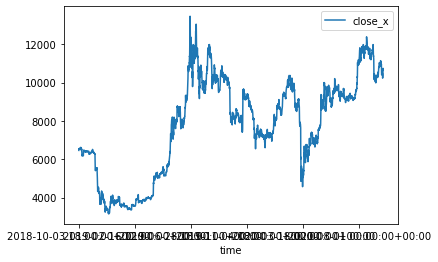

In [75]:
test_df[['close_x']].plot()

In [76]:
# Prep Test Data Frame

test_df['btcusd_change'] = test_df['btcusd_price'].pct_change()
test_df['ethbtc_change'] = test_df['ethbtc_price'].pct_change()

In [77]:
test_df.head()

,Real,y_test,Predicted,Accuracy_Test,price_velocity_2,price_velocity_3,price_velocity_4,price_velocity_7,price_velocity_30,price_acceleration_1,...,rolling_mean_velocity_30,rolling_mean_acceleration_2,rolling_mean_acceleration_3,rolling_mean_acceleration_4,rolling_mean_acceleration_7,rolling_mean_acceleration_30,btcusd_price,ethbtc_price,btcusd_change,ethbtc_change
time,,,,,,,,,,,,,,,,,,,,,
2018-10-03 18:00:00+00:00,3,3,3,True,0.001953,0.004913,-0.005554,-0.017465,0.004491,-1.240345,...,0.000187,-0.684617,-0.884279,-3.828709,-3.348702,0.405056,6463.9,0.03391,NaN,NaN
2018-10-04 00:00:00+00:00,5,5,5,True,0.012384,0.014989,0.017987,0.001177,0.016786,-22.038011,...,0.000595,-11.639178,-7.802415,-6.172712,-5.467872,-0.299610,6548.0,0.03415,0.013011,0.007078
2018-10-04 06:00:00+00:00,2,2,2,True,0.010489,0.009864,0.012463,0.005774,0.000505,-1.191328,...,0.000054,-11.614669,-8.156561,-6.149643,-5.667269,-0.907570,6531.7,0.03396,-0.002489,-0.005564
2018-10-04 12:00:00+00:00,5,5,5,True,0.000657,0.013676,0.013049,0.008046,0.015310,-2.266958,...,0.000542,-1.729143,-8.498765,-6.684160,-5.830162,-0.921974,6552.3,0.03388,0.003154,-0.002356
2018-10-04 18:00:00+00:00,3,3,3,True,0.002404,-0.000092,0.012918,0.017894,0.012746,-1.237116,...,0.000457,-1.752037,-1.565134,-6.683353,-4.198036,-0.924700,6547.4,0.03375,-0.000748,-0.003837


In [78]:
test_df.isna().sum()

Real                            0
y_test                          0
Predicted                       0
Accuracy_Test                   0
price_velocity_2                0
price_velocity_3                0
price_velocity_4                0
price_velocity_7                0
price_velocity_30               0
price_acceleration_1            0
price_acceleration_2            0
price_acceleration_3            0
price_acceleration_4            0
price_acceleration_7            0
price_acceleration_30           0
rolling_mean_velocity_2         0
rolling_mean_velocity_3         0
rolling_mean_velocity_4         0
rolling_mean_velocity_7         0
rolling_mean_velocity_30        0
rolling_mean_acceleration_2     0
rolling_mean_acceleration_3     0
rolling_mean_acceleration_4     0
rolling_mean_acceleration_7     0
rolling_mean_acceleration_30    0
btcusd_price                    0
ethbtc_price                    0
btcusd_change                   1
ethbtc_change                   1
dtype: int64

In [79]:
test_df.drop(columns = ['btcusd_change', 'ethbtc_change'], inplace=True)

In [111]:
test_df

,time,Real,y_test,Predicted,Accuracy_Test,price_velocity_2,price_velocity_3,price_velocity_4,price_velocity_7,price_velocity_30,...,rolling_mean_velocity_4,rolling_mean_velocity_7,rolling_mean_velocity_30,rolling_mean_acceleration_2,rolling_mean_acceleration_3,rolling_mean_acceleration_4,rolling_mean_acceleration_7,rolling_mean_acceleration_30,btcusd_price,ethbtc_price
0,2018-10-03 18:00:00+00:00,3,3,3,True,0.001953,0.004913,-0.005554,-0.017465,0.004491,...,-0.001377,-0.002502,0.000187,-0.684617,-0.884279,-3.828709,-3.348702,0.405056,6463.9,0.03391
1,2018-10-04 00:00:00+00:00,5,5,5,True,0.012384,0.014989,0.017987,0.001177,0.016786,...,0.004480,0.000193,0.000595,-11.639178,-7.802415,-6.172712,-5.467872,-0.299610,6548.0,0.03415
2,2018-10-04 06:00:00+00:00,2,2,2,True,0.010489,0.009864,0.012463,0.005774,0.000505,...,0.003119,0.000844,0.000054,-11.614669,-8.156561,-6.149643,-5.667269,-0.907570,6531.7,0.03396
3,2018-10-04 12:00:00+00:00,5,5,5,True,0.000657,0.013676,0.013049,0.008046,0.015310,...,0.003264,0.001167,0.000542,-1.729143,-8.498765,-6.684160,-5.830162,-0.921974,6552.3,0.03388
4,2018-10-04 18:00:00+00:00,3,3,3,True,0.002404,-0.000092,0.012918,0.017894,0.012746,...,0.003232,0.002548,0.000457,-1.752037,-1.565134,-6.683353,-4.198036,-0.924700,6547.4,0.03375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2707,2020-09-24 00:00:00+00:00,5,5,5,True,-0.016568,-0.018491,-0.017854,-0.016182,-0.067854,...,-0.004439,-0.002289,-0.002293,4.478796,1.648281,0.957137,-0.209696,0.377532,10286.7,0.03417
2708,2020-09-24 06:00:00+00:00,5,5,5,True,0.017604,-0.004704,-0.006650,-0.007323,-0.049338,...,-0.001585,-0.000999,-0.001636,-0.022844,3.387200,1.537212,0.448669,0.473161,10410.8,0.03417
2709,2020-09-24 12:00:00+00:00,5,5,5,True,0.037884,0.043565,0.020688,0.013662,-0.022263,...,0.005282,0.002034,-0.000689,1.159352,0.356337,2.819074,0.549037,0.531074,10676.4,0.03244
2710,2020-09-24 18:00:00+00:00,5,5,5,True,0.031640,0.044086,0.049801,0.025445,-0.012849,...,0.012256,0.003685,-0.000369,0.174466,0.517647,0.075811,0.768784,0.497095,10740.2,0.03244


In [ ]:
# Input Variables (defining variables for backtest) 
test_df = test_df # Dataframe with predictions on test data
initial_capital = 50000000 # USD
exchange = 'kraken'
rebalance_freq = 6 #Hours
start = 
end = 
fee_perc = 
tax_fee = 

In [112]:
btc_wts = [.2,.4,.5,.5,.4]
usd_wts = [.8,.6,.4,.2, 0]
alt_wts = [0,0,.1,.3,.6]
# Create balance lists to populate when looping through dataframe
bucket_1_position = [] # USD
bucket_2_position = [] # BTC
bucket_3_position = [] # ETH
time_list = []

In [88]:
test_df.reset_index(inplace=True)

In [92]:
# 1- iterate through rows in predictions data frame and assign designated weight given the predicted category
# 2- append weights to position lists
# 3- Create Positions Dataframe
# 4- Shift positions up one timestamp (These are predictions for the next row, therefore the rebalance needs to take place 1 candle back)
# 5- Merge new Positions dataframe with price data and add balance_usd and balance_btc dataframes
for index, row in test_df.iterrows():  
    # Strategy Logic    
    if row['Predicted'] == 5: # Very Bull
        bucket_1_position.append(usd_wts[4])
        bucket_2_position.append(btc_wts[4])
        bucket_3_position.append(alt_wts[4])
        time_list.append(row['time'])
    elif row['Predicted'] == 4: # Bull
        bucket_1_position.append(usd_wts[3])
        bucket_2_position.append(btc_wts[3])
        bucket_3_position.append(alt_wts[3])
        time_list.append(row['time'])          
    elif row['Predicted'] == 3: # Neutral
        bucket_1_position.append(usd_wts[2])
        bucket_2_position.append(btc_wts[2])
        bucket_3_position.append(alt_wts[2])
        time_list.append(row['time'])
    elif row['Predicted'] == 2: # Bear
        bucket_1_position.append(usd_wts[1])
        bucket_2_position.append(btc_wts[1])
        bucket_3_position.append(alt_wts[1])
        time_list.append(row['time'])
    elif row['Predicted'] == 1: # Very Bear
        bucket_1_position.append(usd_wts[0])
        bucket_2_position.append(btc_wts[0])
        bucket_3_position.append(alt_wts[0])
        time_list.append(row['time'])

# Create positions dataframe  
positions_df = pd.DataFrame(list(zip(time_list, bucket_1_position, bucket_2_position, bucket_3_position)),
                             columns =['time', 'bucket_1_position', 'bucket_2_position', 'bucket_3_position'])   


In [93]:
positions_df.head()

,time,bucket_1_position,bucket_2_position,bucket_3_position
0,2018-10-03 18:00:00+00:00,0.4,0.5,0.1
1,2018-10-04 00:00:00+00:00,0.0,0.4,0.6
2,2018-10-04 06:00:00+00:00,0.6,0.4,0.0
3,2018-10-04 12:00:00+00:00,0.0,0.4,0.6
4,2018-10-04 18:00:00+00:00,0.4,0.5,0.1


In [94]:
shifted_positions_df = positions_df.copy()
shifted_positions_df[['bucket_1_position','bucket_2_position', 'bucket_3_position']] = shifted_positions_df[['bucket_1_position','bucket_2_position', 'bucket_3_position']].shift(-1)
shifted_positions_df.head()

,time,bucket_1_position,bucket_2_position,bucket_3_position
0,2018-10-03 18:00:00+00:00,0.0,0.4,0.6
1,2018-10-04 00:00:00+00:00,0.6,0.4,0.0
2,2018-10-04 06:00:00+00:00,0.0,0.4,0.6
3,2018-10-04 12:00:00+00:00,0.4,0.5,0.1
4,2018-10-04 18:00:00+00:00,0.6,0.4,0.0


In [96]:
btcusd_6h_historical.reset_index(inplace=True)
ethbtc_6h_historical.reset_index(inplace=True)

In [97]:
shifted_positions_df = pd.merge(shifted_positions_df, btcusd_6h_historical, how='left', on='time')
shifted_positions_df = pd.merge(shifted_positions_df, ethbtc_6h_historical, how='left', on='time')
shifted_positions_df['btcusd_price'] = shifted_positions_df['close_x']
shifted_positions_df['ethbtc_price'] = shifted_positions_df['close_y']
shifted_positions_df.drop(columns=['close_x', 'close_y'], inplace=True)
shifted_positions_df['ethbtc_price'].fillna(method='ffill', inplace=True)

In [98]:
shifted_positions_df

,time,bucket_1_position,bucket_2_position,bucket_3_position,btcusd_price,ethbtc_price
0,2018-10-03 18:00:00+00:00,0.0,0.4,0.6,6463.9,0.03391
1,2018-10-04 00:00:00+00:00,0.6,0.4,0.0,6548.0,0.03415
2,2018-10-04 06:00:00+00:00,0.0,0.4,0.6,6531.7,0.03396
3,2018-10-04 12:00:00+00:00,0.4,0.5,0.1,6552.3,0.03388
4,2018-10-04 18:00:00+00:00,0.6,0.4,0.0,6547.4,0.03375
...,...,...,...,...,...,...
5419,2020-09-24 00:00:00+00:00,0.0,0.4,0.6,10286.7,0.03417
5420,2020-09-24 06:00:00+00:00,0.0,0.4,0.6,10410.8,0.03417
5421,2020-09-24 12:00:00+00:00,0.0,0.4,0.6,10676.4,0.03244
5422,2020-09-24 18:00:00+00:00,0.8,0.2,0.0,10740.2,0.03244


In [99]:
bucket_1_balance_usd = []
bucket_2_balance_usd = []
bucket_3_balance_usd = []
portfolio_balance_usd = []
bucket_1_balance_btc = []
bucket_2_balance_btc = []
bucket_3_balance_btc = []
portfolio_balance_btc = []


In [109]:
if len(portfolio_balance_usd) == 0:
    print(portfolio_balance_usd)

[]


In [110]:
initial_capital = 50000000

In [ ]:
for index, row in shifted_positions_df.iterrows():
    b1_balance_btc = 
    if len(portfolio_balance_usd) == 0:
        portfolio_balance_usd.append(initial_capital)
    else:
        portfolio_balance_usd.append(b1_balance_usd)
    

In [ ]:
def return_analysis(test_df, initial_capital, exchange, rebalance_freq, start, end, fee_perc, tax_fee):
    name_of_model = 'XGB Multi-Classifier'
    initial_capital = float(initial_capital)
    # BTC-USD Trend thresholds
    very_bullish = 5 # if btc price prediction is greater than threshold
    bullish = 4 # if btc
    nuetral = 3 # if btc is predicting 0 returns
    bearish = 2 # if btc is predicting negative returns
    very_bearish = 1 # if btci predicting very negative returns
    # Set Threshold Weights (create global variables as input...)
    # ***** figure out how to train a model to predict class ranges for trend thresholds
    # ***** figure out how to train a model to predict best allocation wts given the class prediction
    btc_wts = [.2,.4,.5,.5,.4]
    usd_wts = [.8,.6,.4,.2, 0]
    alt_wts = [0,0,.1,.3,.6]
    # Create balance lists to populate when looping through dataframe
    bucket_1_position = []
    bucket_2_position = []
    bucket_3_position = []
    time = []
    # 1- iterate through rows in test data frame and assign designated weight given the predicted category
    # 2- append weights to position lists
    # 3- Create Positions Dataframe
    # 4- Shift positions up one timestamp (These are predictions for the next row, therefore the rebalance needs to take place 1 candle back)
    # 5- Merge new Positions dataframe with price data and add balance_usd and balance_btc dataframes
    for index, row in test_df.iterrows():  
        # Strategy Logic    
        if row['predicted_class'] == 5: # Very Bull
            bucket_1_position.append(usd_wts[4])
            bucket_2_position.append(btc_wts[4])
            bucket_3_position.append(alt_wts[4])
            time.append(row['time'])
        elif row['predicted_class'] == 4: # Bull
            bucket_1_position.append(usd_wts[3])
            bucket_2_position.append(btc_wts[3])
            bucket_3_position.append(alt_wts[3])
            time.append(row['time'])          
        elif row['predicted_class'] == 3: # Neutral
            bucket_1_position.append(usd_wts[2])
            bucket_2_position.append(btc_wts[2])
            bucket_3_position.append(alt_wts[2])
            time.append(row['time'])
        elif row['predicted_class'] == 2: # Bear
            bucket_1_position.append(usd_wts[1])
            bucket_2_position.append(btc_wts[1])
            bucket_3_position.append(alt_wts[1])
            time.append(row['time'])
        elif row['predicted_class'] == 1: # Very Bear
            bucket_1_position.append(usd_wts[0])
            bucket_2_position.append(btc_wts[0])
            bucket_3_position.append(alt_wts[0])
            time.append(row['time'])

    # Create positions dataframe  
    positions_df = pd.DataFrame(list(zip(time, bucket_1_position, bucket_2_position, bucket_3_position)),
                                 columns =['time', 'bucket_1_position', 'bucket_2_position', 'bucket_3_position'])   
    
    # Merge positions dataframe with backtest dataframe
    final_backtest_df = pd.merge(test_df, positions_df, how='left', on='time')
    # Market Dynamics Columns
    final_backtest_df['btc_price_change'] = backtest_df['btc_price'].pct_change()
    final_backtest_df['eth_price_change'] = backtest_df['ethbtc_price'].pct_change()
    # Portfolio Columns
    final_backtest_df['portfolio_balance_usd'] = final_backtest_df['bucket_1_position'] 
    final_backtest_df['portfolio_returns_usd'] =  final
    final_backtest_df['portfolio_cum_returns_usd'] = 
    final_backtest_df['portfolio_balance_btc'] = 
    final_backtest_df['portfolio_returns_btc'] =
    final_backtest_df['portfolio_cum_returns_btc'] =
    # Position Columns
    final_backtest_df['bucket_1_position_change'] = backtest_df['bucket_1_position'].diff()
    final_backtest_df['bucket_2_position_change'] = backtest_df['bucket_2_position'].diff()
    final_backtest_df['bucket_3_position_change'] = backtest_df['bucket_3_position'].diff()
    
    
    
    # ---------------------------------- Calc Portfolio Performance ------------------------
    
    #backtest_results_df1['alpha'] = backtest_results_df1['usd_cum_returns'] - backtest_results_df1['btcusd_cum_returns']
    #backtest_results_df1['usd_rolling_returns_wk'] = backtest_results_df1['usd_perc_change'].rolling(7).sum()
    #backtest_results_df1['btc_rolling_returns_wk'] = backtest_results_df1['btc_perc_change'].rolling(7).sum()
    #backtest_results_df1['usd_rolling_vol_wk'] = backtest_results_df1['usd_perc_change'].rolling(7).std()
    #backtest_results_df1['btc_rolling_vol_wk'] = backtest_results_df1['btc_perc_change'].rolling(7).std()
    #backtest_results_df1['usd_rolling_returns_mo'] = backtest_results_df1['usd_perc_change'].rolling(7).sum()
    #backtest_results_df1['btc_rolling_returns_mo'] = backtest_results_df1['btc_perc_change'].rolling(7).sum()
    #backtest_results_df1['usd_rolling_vol_mo'] = backtest_results_df1['usd_perc_change'].rolling(30).std()
    #backtest_results_df1['btc_rolling_vol_mo'] = backtest_results_df1['btc_perc_change'].rolling(30).std()
    #
    #backtest_results_df1['usd_rolling_sharpe_wk'] = backtest_results_df1['usd_rolling_returns_wk']/backtest_results_df1['usd_rolling_vol_wk']
    #backtest_results_df1['btc_rolling_sharpe_wk'] = backtest_results_df1['btc_rolling_returns_wk']/backtest_results_df1['btc_rolling_vol_wk']
    #backtest_results_df1['usd_rolling_sharpe_mo'] = backtest_results_df1['usd_rolling_returns_mo']/backtest_results_df1['usd_rolling_vol_mo']
    #backtest_results_df1['btc_rolling_sharpe_mo'] = backtest_results_df1['btc_rolling_returns_mo']/backtest_results_df1['btc_rolling_vol_mo']
    
    # More Risk Measures
        # Max Drawdown 
        # Skewness
        # Kurtosis
        # VAR
        # CVAR
        # Time under water   
    usd_metrics= [
        'initial_capital',
        'cumulative_returns',
        'annualized_returns',
        'mthly_returns',
        'annual_vol',
        'mthly_vol',
        'annual_sharpe',
        'mthly_sharpe',
        'annual_sortino',
        'mthly_sortino',
    ]
    
    btc_metrics = [
        
        'initial_capital',
        'cumulative_returns',
        'annualized_returns',
        'mthly_returns',
        'annual_vol',
        'mthly_vol',
        'annual_sharpe',
        'mthly_sharpe',
        'annual_sortino',
        'mthly_sortino',
    ]
    
    columns = ['Backtest']
    
    port_eval_df_usd = pd.DataFrame(index=usd_metrics, columns=columns)
    
    port_eval_df_usd.loc['initial_capital'] = initial_capital
    port_eval_df_usd.loc['cumulative_returns'] = final_backtest_df['portfolio_cum_returns_usd'].iloc[-1]
    port_eval_df_usd.loc['annualized_returns'] = final_backtest_df['portfolio_returns_usd'].mean() *365  #Crypto trades 365 days per year
    port_eval_df_usd.loc['mthly_returns'] = final_backtest_df['portfolio_returns_usd'].mean() *30
    port_eval_df_usd.loc['annual_vol'] = final_backtest_df['portfolio_returns_usd'].std() * np.sqrt(365)  #Crypto trades 365 days per year
    port_eval_df_usd.loc['mthly_vol'] = final_backtest_df['portfolio_returns_usd'].std() * np.sqrt(30)
    port_eval_df_usd.loc['annual_sharpe'] = port_eval_df_usd.loc['annualized_returns']/port_eval_df_usd.loc['annual_vol']
    port_eval_df_usd.loc['mthly_sharpe'] = port_eval_df_usd.loc['mthly_returns']/port_eval_df_usd.loc['mthly_vol']
        
    
    port_eval_df_btc = pd.DataFrame(index=btc_metrics, columns=columns)
    port_eval_df_btc.loc['initial_capital'] = final_backtest_df['portfolio_balance_btc'].iloc[0]
    port_eval_df_btc.loc['cumulative_returns'] = final_backtest_df['portfolio_cum_returns_btc'].iloc[-1]
    port_eval_df_btc.loc['annualized_returns'] = final_backtest_df['portfolio_returns_btc'].mean() *365  #Crypto trades 365 days per year
    port_eval_df_btc.loc['mthly_returns'] = final_backtest_df['portfolio_returns_btc'].mean() *30
    port_eval_df_btc.loc['annual_vol'] = final_backtest_df['portfolio_returns_btc'].mean() * np.sqrt(365) #Crypto trades 365 days per year
    port_eval_df_btc.loc['mthly_vol'] = final_backtest_df['portfolio_returns_btc'].mean() * np.sqrt(30)
    port_eval_df_btc.loc['annual_sharpe'] = port_eval_df_btc.loc['annualized_returns']/port_eval_df_btc.loc['annual_vol']
    port_eval_df_btc.loc['mthly_sharpe'] = port_eval_df_btc.loc['mthly_returns']/port_eval_df_btc.loc['mthly_vol']
    
    # Calculate Sortino Ratios
    sortino_ratio_df = final_backtest_df[['portfolio_returns_usd','portfolio_returns_btc']].copy()
    sortino_ratio_df.loc[:, "downside_usd"] = 0
    sortino_ratio_df.loc[:,"downside_btc"] = 0
    target = 0
    mask_usd = sortino_ratio_df['portfolio_returns_usd'] < target
    mask_btc = sortino_ratio_df['portfolio_returns_btc'] < target
    
    sortino_ratio_df.loc[mask_usd, "portfolio_returns_usd"] = (sortino_ratio_df["portfolio_returns_usd"]**2)
    sortino_ratio_df.loc[mask_btc, "portfolio_returns_btc"] = (sortino_ratio_df["portfolio_returns_btc"]**2)
    
    down_stdev_usd_annual = np.sqrt(sortino_ratio_df['downside_usd'].mean()) * np.sqrt(365)
    down_stdev_btc_annual = np.sqrt(sortino_ratio_df['downside_btc'].mean()) * np.sqrt(365)
    down_stdev_btc_mthly = np.sqrt(sortino_ratio_df['downside_btc'].mean()) * np.sqrt(30)
    down_stdev_usd_mthly = np.sqrt(sortino_ratio_df['downside_usd'].mean()) * np.sqrt(30)
    
    expected_return_usd_annual = sortino_ratio_df['portfolio_returns_usd'].mean()*365
    expected_return_btc_annual = sortino_ratio_df['portfolio_returns_btc'].mean()*365
    sortino_ratio_usd_annual = expected_return_usd_annual/down_stdev_usd_annual
    sortino_ratio_btc_annual = expected_return_btc_annual/down_stdev_btc_annual
    
    expected_return_usd_mthly = sortino_ratio_df['portfolio_returns_usd'].mean()*30
    expected_return_btc_mthly = sortino_ratio_df['portfolio_returns_btc'].mean()*30
    
    sortino_ratio_usd_mthly = expected_return_usd_mthly/down_stdev_usd_mthly
    sortino_ratio_btc_mthly = expected_return_btc_mthly/down_stdev_btc_mthly
    
    port_eval_df_usd.loc['annual_sortino'] = sortino_ratio_usd_annual
    port_eval_df_usd.loc['mthly_sortino'] = sortino_ratio_usd_mthly
    port_eval_df_btc.loc['annual_sortino'] = sortino_ratio_btc_annual
    port_eval_df_btc.loc['mthly_sortino'] = sortino_ratio_usd_mthly
    
    
    
    
    # --------------------------------------------- print Performance stats ------------------------------------------
    # Print out Performance Tables
    print(port_eval_df_usd)
    print(port_eval_df_btc)
    
    # Risk Visualizations    
    #final_backtest_df['rolling_sharpe'] !!!! NEED TO MAKE SURE THERE IS A ROW EVERY 6 HOURS
    final_backtest_df[['portfolio_returns_usd', 'portfolio_returns_btc']]
    # Reward Measures
    final_backtest_df['portfolio_cum_returns_usd'].plot()
    final_backtest_df['portfolio_cum_returns_btc'].plot()  
    final_backtest_df['portfolio_returns_usd'].plot()
    final_backtest_df['portfolio_returns_btc'].plot()
    


        
    

## DATA VIZ PURPOSES ONLY

In [18]:
import shrimpy
# Set environment variables from the .env file
env_path = Path("/Users/gdepa")/'grant_api_keys.env'
load_dotenv(env_path)

shrimpy_public_key = os.getenv("SHRIMPY_DEV_PUBLIC")
shrimpy_private_key = os.getenv("SHRIMPY_DEV_SECRET")

client = shrimpy.ShrimpyApiClient(shrimpy_public_key, shrimpy_private_key)

In [19]:
backtest_results = client.run_backtest( 'kraken', 1, .1,'2018-05-19T00:00:00.000Z', '2020-08-14T00:00:00.000Z', 100000, 
                                      [
                                          {'symbol':"XBT", 'percent': '50'},
                                          {'symbol': "ETH", 'percent': '50'}
                                      ])

In [20]:
backtest_results

{'rebalanceData': [{'time': '2018-05-19T00:00:00.000Z',
   'usdValue': 100000.00000000001},
  {'time': '2018-05-20T00:59:55.415Z', 'usdValue': 100033.28612056647},
  {'time': '2018-05-21T00:59:51.015Z', 'usdValue': 103713.09141822706},
  {'time': '2018-05-22T00:59:46.614Z', 'usdValue': 101064.78450178646},
  {'time': '2018-05-23T00:59:42.213Z', 'usdValue': 95903.87463446634},
  {'time': '2018-05-24T00:59:37.812Z', 'usdValue': 88705.94720954724},
  {'time': '2018-05-25T00:59:33.412Z', 'usdValue': 88471.87295284402},
  {'time': '2018-05-26T00:59:29.011Z', 'usdValue': 86710.97690446931},
  {'time': '2018-05-27T00:59:24.610Z', 'usdValue': 88380.9321365447},
  {'time': '2018-05-28T00:59:20.209Z', 'usdValue': 85296.9310745698},
  {'time': '2018-05-29T00:59:15.809Z', 'usdValue': 79656.76858799503},
  {'time': '2018-05-30T00:59:11.408Z', 'usdValue': 85943.72787459996},
  {'time': '2018-05-31T00:59:07.007Z', 'usdValue': 84359.37745900969},
  {'time': '2018-06-01T00:59:02.606Z', 'usdValue': 8665

In [21]:
def execute_backtest(initial_capital, exchange,rebalance_freq,starttime, endtime, fee_perc):
    backtest_results = client.run_backtest(exchange, rebalance_freq, fee_perc,starttime,endtime, initial_capital, 
                                      [
                                          {'symbol':"XBT", 'percent': '50'},
                                          {'symbol': "ETH", 'percent': '50'}
                                      ])
    backtest_results_df = pd.DataFrame(columns=['time', 'usdValue'])
    results = backtest_results['holdingData']
    for index, value in enumerate(results):
        #print(value)
        backtest_results_df.loc[index] = [(value['time']), value['usdValue']]

    backtest_results_df['time'] = pd.to_datetime(backtest_results_df['time'])
    backtest_results_df['time'] = backtest_results_df['time'].dt.round('D')
    
    candles_df = pd.DataFrame(columns=['time', 'btcusd'])
    candles = client.get_candles('kraken','xbt', 'usd', '1d',starttime)
    for key, value in enumerate(candles):
        candles_df.loc[key] = [pd.to_datetime(value['time']), value['close']]
    candles_df['time'] = pd.to_datetime(candles_df['time'])
    
    backtest_results_df0 = pd.merge(candles_df,backtest_results_df, on='time', how='left')
    backtest_results_df0 = backtest_results_df0.set_index('time')
    backtest_results_df0 = backtest_results_df0.apply(pd.to_numeric)
    return backtest_results_df0


In [22]:
backtest_df = execute_backtest(100000, 'kraken',1, '2018-05-19T00:00:00.000Z', '2020-08-14T00:00:00.000Z', 0.1)

In [23]:
backtest_df.head()

,btcusd,usdValue
time,,
2018-05-19 00:00:00+00:00,8233.8,100000.000000
2018-05-20 00:00:00+00:00,8518.9,100030.798105
2018-05-21 00:00:00+00:00,8390.8,103708.733493
2018-05-22 00:00:00+00:00,7989.1,101061.259467
2018-05-23 00:00:00+00:00,7500.3,95916.001791


<AxesSubplot:xlabel='time'>

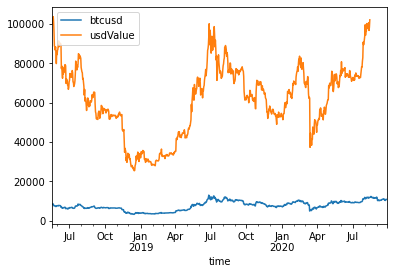

In [24]:
backtest_df.plot()

In [ ]:
def backtest_performance_viz(backtest_df):
    # ---------------------------------- Calc Portfolio Performance ------------------------
    
    #backtest_results_df1['alpha'] = backtest_results_df1['usd_cum_returns'] - backtest_results_df1['btcusd_cum_returns']
    #backtest_results_df1['usd_rolling_returns_wk'] = backtest_results_df1['usd_perc_change'].rolling(7).sum()
    #backtest_results_df1['btc_rolling_returns_wk'] = backtest_results_df1['btc_perc_change'].rolling(7).sum()
    #backtest_results_df1['usd_rolling_vol_wk'] = backtest_results_df1['usd_perc_change'].rolling(7).std()
    #backtest_results_df1['btc_rolling_vol_wk'] = backtest_results_df1['btc_perc_change'].rolling(7).std()
    #backtest_results_df1['usd_rolling_returns_mo'] = backtest_results_df1['usd_perc_change'].rolling(7).sum()
    #backtest_results_df1['btc_rolling_returns_mo'] = backtest_results_df1['btc_perc_change'].rolling(7).sum()
    #backtest_results_df1['usd_rolling_vol_mo'] = backtest_results_df1['usd_perc_change'].rolling(30).std()
    #backtest_results_df1['btc_rolling_vol_mo'] = backtest_results_df1['btc_perc_change'].rolling(30).std()
    #
    #backtest_results_df1['usd_rolling_sharpe_wk'] = backtest_results_df1['usd_rolling_returns_wk']/backtest_results_df1['usd_rolling_vol_wk']
    #backtest_results_df1['btc_rolling_sharpe_wk'] = backtest_results_df1['btc_rolling_returns_wk']/backtest_results_df1['btc_rolling_vol_wk']
    #backtest_results_df1['usd_rolling_sharpe_mo'] = backtest_results_df1['usd_rolling_returns_mo']/backtest_results_df1['usd_rolling_vol_mo']
    #backtest_results_df1['btc_rolling_sharpe_mo'] = backtest_results_df1['btc_rolling_returns_mo']/backtest_results_df1['btc_rolling_vol_mo']
    
    # More Risk Measures
        # Max Drawdown 
        # Skewness
        # Kurtosis
        # VAR
        # CVAR
        # Time under water   
    usd_metrics= [
        'initial_capital',
        'cumulative_returns',
        'annualized_returns',
        'mthly_returns',
        'annual_vol',
        'mthly_vol',
        'annual_sharpe',
        'mthly_sharpe',
        'annual_sortino',
        'mthly_sortino',
    ]
    
    btc_metrics = [
        
        'initial_capital',
        'cumulative_returns',
        'annualized_returns',
        'mthly_returns',
        'annual_vol',
        'mthly_vol',
        'annual_sharpe',
        'mthly_sharpe',
        'annual_sortino',
        'mthly_sortino',
    ]
    
    columns = ['Backtest']
    
    port_eval_df_usd = pd.DataFrame(index=usd_metrics, columns=columns)
    
    port_eval_df_usd.loc['initial_capital'] = initial_capital
    port_eval_df_usd.loc['cumulative_returns'] = final_backtest_df['portfolio_cum_returns_usd'].iloc[-1]
    port_eval_df_usd.loc['annualized_returns'] = final_backtest_df['portfolio_returns_usd'].mean() *365  #Crypto trades 365 days per year
    port_eval_df_usd.loc['mthly_returns'] = final_backtest_df['portfolio_returns_usd'].mean() *30
    port_eval_df_usd.loc['annual_vol'] = final_backtest_df['portfolio_returns_usd'].std() * np.sqrt(365)  #Crypto trades 365 days per year
    port_eval_df_usd.loc['mthly_vol'] = final_backtest_df['portfolio_returns_usd'].std() * np.sqrt(30)
    port_eval_df_usd.loc['annual_sharpe'] = port_eval_df_usd.loc['annualized_returns']/port_eval_df_usd.loc['annual_vol']
    port_eval_df_usd.loc['mthly_sharpe'] = port_eval_df_usd.loc['mthly_returns']/port_eval_df_usd.loc['mthly_vol']
        
    
    port_eval_df_btc = pd.DataFrame(index=btc_metrics, columns=columns)
    port_eval_df_btc.loc['initial_capital'] = final_backtest_df['portfolio_balance_btc'].iloc[0]
    port_eval_df_btc.loc['cumulative_returns'] = final_backtest_df['portfolio_cum_returns_btc'].iloc[-1]
    port_eval_df_btc.loc['annualized_returns'] = final_backtest_df['portfolio_returns_btc'].mean() *365  #Crypto trades 365 days per year
    port_eval_df_btc.loc['mthly_returns'] = final_backtest_df['portfolio_returns_btc'].mean() *30
    port_eval_df_btc.loc['annual_vol'] = final_backtest_df['portfolio_returns_btc'].mean() * np.sqrt(365) #Crypto trades 365 days per year
    port_eval_df_btc.loc['mthly_vol'] = final_backtest_df['portfolio_returns_btc'].mean() * np.sqrt(30)
    port_eval_df_btc.loc['annual_sharpe'] = port_eval_df_btc.loc['annualized_returns']/port_eval_df_btc.loc['annual_vol']
    port_eval_df_btc.loc['mthly_sharpe'] = port_eval_df_btc.loc['mthly_returns']/port_eval_df_btc.loc['mthly_vol']
    
    # Calculate Sortino Ratios
    sortino_ratio_df = final_backtest_df[['portfolio_returns_usd','portfolio_returns_btc']].copy()
    sortino_ratio_df.loc[:, "downside_usd"] = 0
    sortino_ratio_df.loc[:,"downside_btc"] = 0
    target = 0
    mask_usd = sortino_ratio_df['portfolio_returns_usd'] < target
    mask_btc = sortino_ratio_df['portfolio_returns_btc'] < target
    
    sortino_ratio_df.loc[mask_usd, "portfolio_returns_usd"] = (sortino_ratio_df["portfolio_returns_usd"]**2)
    sortino_ratio_df.loc[mask_btc, "portfolio_returns_btc"] = (sortino_ratio_df["portfolio_returns_btc"]**2)
    
    down_stdev_usd_annual = np.sqrt(sortino_ratio_df['downside_usd'].mean()) * np.sqrt(365)
    down_stdev_btc_annual = np.sqrt(sortino_ratio_df['downside_btc'].mean()) * np.sqrt(365)
    down_stdev_btc_mthly = np.sqrt(sortino_ratio_df['downside_btc'].mean()) * np.sqrt(30)
    down_stdev_usd_mthly = np.sqrt(sortino_ratio_df['downside_usd'].mean()) * np.sqrt(30)
    
    expected_return_usd_annual = sortino_ratio_df['portfolio_returns_usd'].mean()*365
    expected_return_btc_annual = sortino_ratio_df['portfolio_returns_btc'].mean()*365
    sortino_ratio_usd_annual = expected_return_usd_annual/down_stdev_usd_annual
    sortino_ratio_btc_annual = expected_return_btc_annual/down_stdev_btc_annual
    
    expected_return_usd_mthly = sortino_ratio_df['portfolio_returns_usd'].mean()*30
    expected_return_btc_mthly = sortino_ratio_df['portfolio_returns_btc'].mean()*30
    
    sortino_ratio_usd_mthly = expected_return_usd_mthly/down_stdev_usd_mthly
    sortino_ratio_btc_mthly = expected_return_btc_mthly/down_stdev_btc_mthly
    
    port_eval_df_usd.loc['annual_sortino'] = sortino_ratio_usd_annual
    port_eval_df_usd.loc['mthly_sortino'] = sortino_ratio_usd_mthly
    port_eval_df_btc.loc['annual_sortino'] = sortino_ratio_btc_annual
    port_eval_df_btc.loc['mthly_sortino'] = sortino_ratio_usd_mthly
    
    
    
    
    # --------------------------------------------- print Performance stats ------------------------------------------
    # Print out Performance Tables
    print(port_eval_df_usd)
    print(port_eval_df_btc)
    
    # Risk Visualizations    
    #final_backtest_df['rolling_sharpe'] !!!! NEED TO MAKE SURE THERE IS A ROW EVERY 6 HOURS
    final_backtest_df[['portfolio_returns_usd', 'portfolio_returns_btc']]
    # Reward Measures
    final_backtest_df['portfolio_cum_returns_usd'].plot()
    final_backtest_df['portfolio_cum_returns_btc'].plot()  
    final_backtest_df['portfolio_returns_usd'].plot()
    final_backtest_df['portfolio_returns_btc'].plot()